# Домашнее задание №2

In [1]:
import csv
import re
import time
from datetime import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from scipy import stats
import seaborn as sns
import urllib.parse
from geopy.distance import geodesic
from shapely.geometry import Point
from sklearn.neighbors import BallTree

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

_______________________

## Часть 1: «Следствие ведёт детектив»

Возьмем датасет из ДЗ №1:

In [3]:
df_mk = pd.read_csv('C:/Users/popov/mirkvartir_df.csv')

Посмотрим на абсолютное и относительное количество пропусков:

In [4]:
df_mk.isnull().sum()

id                    0
url                   0
title                 0
description           1
price                 0
latitude              0
longitude             0
metro_name         1319
address               0
agency_name           0
photos_count          0
photos                0
main_photo_url        0
update_time           0
source                0
rooms               186
area                  0
floor                 0
total_floors          0
price_per_sqm         0
dist_to_metro         0
dist_to_park          0
dist_to_water         0
dist_to_airport       0
dtype: int64

In [5]:
missing_values = df_mk.isnull().sum()
missing_percentage = (missing_values / len(df_mk)) * 100
print("Процент пропущенных значений в каждом столбце:")
missing_percentage

Процент пропущенных значений в каждом столбце:


id                  0.000000
url                 0.000000
title               0.000000
description         0.020483
price               0.000000
latitude            0.000000
longitude           0.000000
metro_name         27.017616
address             0.000000
agency_name         0.000000
photos_count        0.000000
photos              0.000000
main_photo_url      0.000000
update_time         0.000000
source              0.000000
rooms               3.809914
area                0.000000
floor               0.000000
total_floors        0.000000
price_per_sqm       0.000000
dist_to_metro       0.000000
dist_to_park        0.000000
dist_to_water       0.000000
dist_to_airport     0.000000
dtype: float64

Построим тепловую карту пропусков, чтобы узнать, расположены ли они случайным образом:

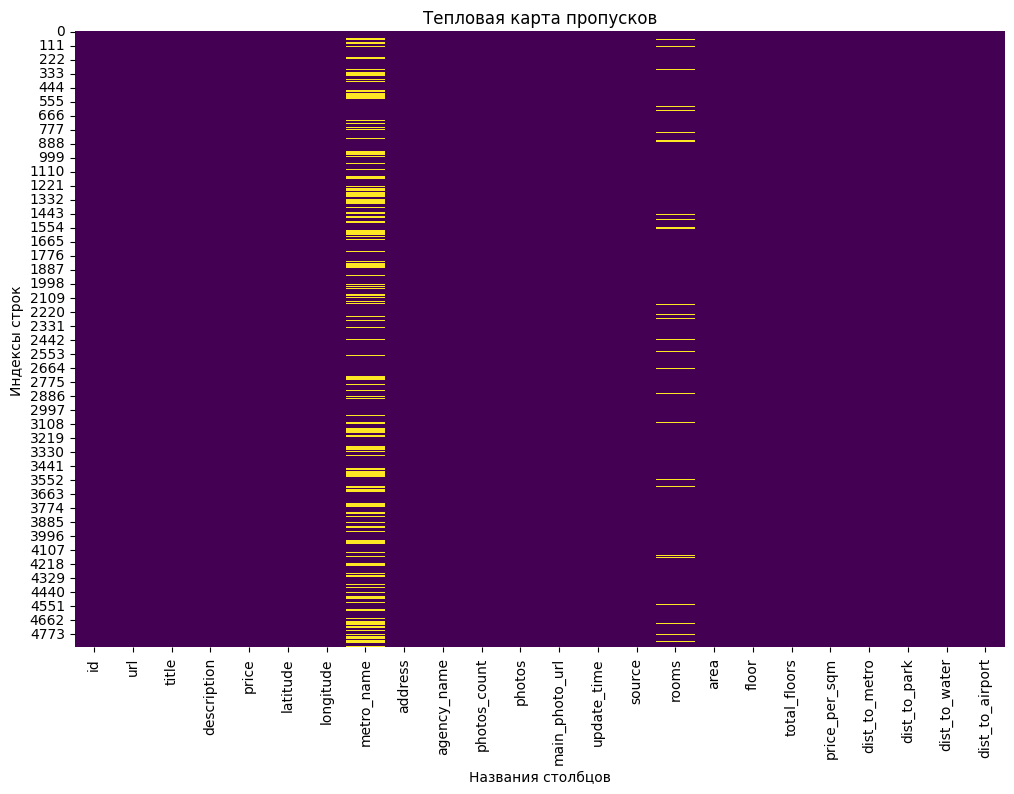

In [6]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_mk.isnull(), cbar=False, cmap='viridis')
plt.title('Тепловая карта пропусков')
plt.xlabel('Названия столбцов')
plt.ylabel('Индексы строк')
plt.show()

Судя по heatmap, пропуски плавно распределены по данным и не идут большими "партиями" подряд.

__________________________________

## Часть 2: «Выбор подходящего оружия»

### Пропуски

#### 1 Столбец `metro_name`

Больше всего пропусков содержит столбец `metro_name` (27,02%). 

Посмотрим на характер пропусков: возможно, они вызваны фактической отдаленностью от метро?

In [7]:
metro_no = df_mk[(df_mk['metro_name'].isna() == True)]
metro_no['dist_to_metro'].describe(percentiles=[.01, .25, .5, .75, .99])

count     1319.000000
mean      6671.418760
std       5292.333685
min        842.387981
1%        2006.235876
25%       3052.621767
50%       4574.092233
75%       8662.394122
99%      25715.841604
max      44724.308640
Name: dist_to_metro, dtype: float64

Минимальное расстояние до метро в данных с пропусками - всего 842 метра, это непорядок.

Для заполнения пропусков можно использовать комплексный подход: заполнить `metro_name` названиями ближайших станций (используя их координаты), где метро действительно близко; в случаях же, когда метро находится слишком далеко, чтобы привязывать объект к его названию, можно заполнить пропуски строкой-заглушкой типа "Далеко от метро".

Но как определить порог, когда мы считаем, что метро далеко? Предлагаю посмотреть на данные, где название метро указано:

In [8]:
metro_yes = df_mk[(df_mk['metro_name'].isna() == False)]
metro_yes['dist_to_metro'].describe(percentiles=[.01, .25, .5, .75, .99])

count     3563.000000
mean      1350.010867
std       1112.816694
min         11.610405
1%         116.064893
25%        654.127009
50%       1057.634022
75%       1674.984323
99%       4547.190611
max      20685.312692
Name: dist_to_metro, dtype: float64

Итак, расстояние до метро в данных без пропущенного названия станции составляет от 11 м до почти 21 км. При этом, 99-й перцентиль указывает на расстояние примерно в 4 км. 

Предлагаю определить это расстояние приемлемым для указания названия ближайшего метро, а в остальных случаях поставить метку "далеко":

In [9]:
# Конфигурация
CITY_NAME = "Санкт-Петербург"
OSM_URL = "https://overpass-api.de/api/interpreter"
TIMEOUT = 25

def get_osm_data(query):
    """Получение данных из OpenStreetMap"""
    try:
        encoded_query = urllib.parse.quote(query)
        full_url = f"{OSM_URL}?data={encoded_query}"
        
        response = requests.get(full_url, timeout=TIMEOUT)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Ошибка при запросе к OSM: {str(e)}")
        print(f"URL запроса: {full_url}")
        return {'elements': []}
    except Exception as e:
        print(f"Неожиданная ошибка: {str(e)}")
        return {'elements': []}

def create_point_gdf(osm_data, name=""):
    """Создание GeoDataFrame из точек OSM"""
    if not osm_data or 'elements' not in osm_data:
        print(f"Нет данных для {name}")
        return None
    
    points = []
    for element in osm_data['elements']:
        if 'lat' in element and 'lon' in element:
            points.append(Point(element['lon'], element['lat']))
        elif 'center' in element:
            points.append(Point(element['center']['lon'], element['center']['lat']))
    
    if not points:
        print(f"Не найдено геометрий для {name}")
        return None
    
    return gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")

# Запросы к Overpass API
metro_query = f"""
    [out:json];
    area[name="{CITY_NAME}"]->.searchArea;
    (
      node[railway=station][station=subway](area.searchArea);
    );
    out body;
    >;
    out skel qt;
"""

raw_metro_data = get_osm_data(metro_query)
metro_gdf = create_point_gdf(raw_metro_data, 'metro')
metro_gdf['name'] = [element['tags'].get('name') for element in raw_metro_data['elements'] if 'tags' in element and 'name' in element['tags']]

# Проверка
if metro_gdf is not None and not metro_gdf.empty:
    print(f"Успешно загружено {len(metro_gdf)} станций метро")

Успешно загружено 70 станций метро


In [10]:
def fast_calculate_distances(df, metro_gdf):
    """Векторизованный расчет расстояний до метро с использованием BallTree"""
    X_apart = np.deg2rad(df[['latitude', 'longitude']].values)
    
    if metro_gdf is None or metro_gdf.empty:
        df['dist_to_metro'] = np.nan
        df['nearest_metro'] = np.nan
        return df

    # Координаты станций метро
    metro_coords = np.array([(geom.y, geom.x) for geom in metro_gdf.geometry])
    X_metro = np.deg2rad(metro_coords)
    
    tree = BallTree(X_metro, metric='haversine')
    
    distances, indices = tree.query(X_apart, k=1)
    df['dist_to_metro'] = distances * 6371000  # Конвертируем в метры
    df['nearest_metro'] = metro_gdf.iloc[indices.flatten()]['name'].values
    
    return df

# Считаем расстояния
df_mk = fast_calculate_distances(df_mk, metro_gdf)

# Пороговое расстояние
distance_threshold = 4547.190611

# Заполнение пропусков
df_mk.loc[df_mk['dist_to_metro'] <= distance_threshold, 'metro_name'] = df_mk.loc[df_mk['dist_to_metro'] <= distance_threshold, 'nearest_metro']
df_mk.loc[df_mk['dist_to_metro'] > distance_threshold, 'metro_name'] = 'далеко'

In [11]:
print("Пропуски в 'metro_name' после заполнения:", df_mk['metro_name'].isnull().sum())

Пропуски в 'metro_name' после заполнения: 0


Посмотрим, какие станции имеются теперь в данных:

In [12]:
unique_metro_names = sorted(df_mk['metro_name'].unique())
unique_metro_names

['Автово',
 'Адмиралтейская',
 'Академическая',
 'Балтийская',
 'Беговая',
 'Бухарестская',
 'Василеостровская',
 'Владимирская',
 'Волковская',
 'Выборгская',
 'Горный институт',
 'Горьковская',
 'Гостиный двор',
 'Гражданский проспект',
 'Достоевская',
 'Дунайская',
 'Елизаровская',
 'Звенигородская',
 'Звёздная',
 'Зенит',
 'Кировский завод',
 'Комендантский проспект',
 'Крестовский остров',
 'Купчино',
 'Ладожская',
 'Ленинский проспект',
 'Лесная',
 'Лиговский проспект',
 'Ломоносовская',
 'Маяковская',
 'Международная',
 'Московская',
 'Московские ворота',
 'Нарвская',
 'Невский проспект',
 'Новочеркасская',
 'Обводный канал',
 'Обухово',
 'Озерки',
 'Парк Победы',
 'Парнас',
 'Петроградская',
 'Пионерская',
 'Площадь Александра Невского 1',
 'Площадь Александра Невского 2',
 'Площадь Восстания',
 'Площадь Ленина',
 'Площадь Мужества',
 'Политехническая',
 'Приморская',
 'Пролетарская',
 'Проспект Большевиков',
 'Проспект Ветеранов',
 'Проспект Просвещения',
 'Проспект Славы',
 '

Список станций корректен, также добавилась метка `далеко`.

In [13]:
metro_yes = df_mk[(df_mk['metro_name'] != 'далеко')]
metro_yes['dist_to_metro'].describe(percentiles=[.01, .25, .5, .75, .99])

count    4184.000000
mean     1583.900431
std      1128.740196
min        11.610405
1%        120.662155
25%       723.056389
50%      1222.340687
75%      2180.251281
99%      4406.994047
max      4540.260088
Name: dist_to_metro, dtype: float64

Все верно, теперь при расстоянии больше порогового значения считается, что метро далеко.

#### 2 Столбец `rooms`

Столбец `rooms` - количество комнат - второй по пропускам (4,88%).

Посмотрим на характер пропусков относительно площади:

In [14]:
rooms_no = df_mk[(df_mk['rooms'].isna() == True)]
rooms_no['area'].describe(percentiles=[.01, .25, .5, .75, .99])

count    186.000000
mean      28.663172
std       46.058529
min       13.000000
1%        13.000000
25%       23.000000
50%       25.000000
75%       28.000000
99%       38.300000
max      650.000000
Name: area, dtype: float64

Построим распределение пропусков в `rooms` в зависимости от площади:

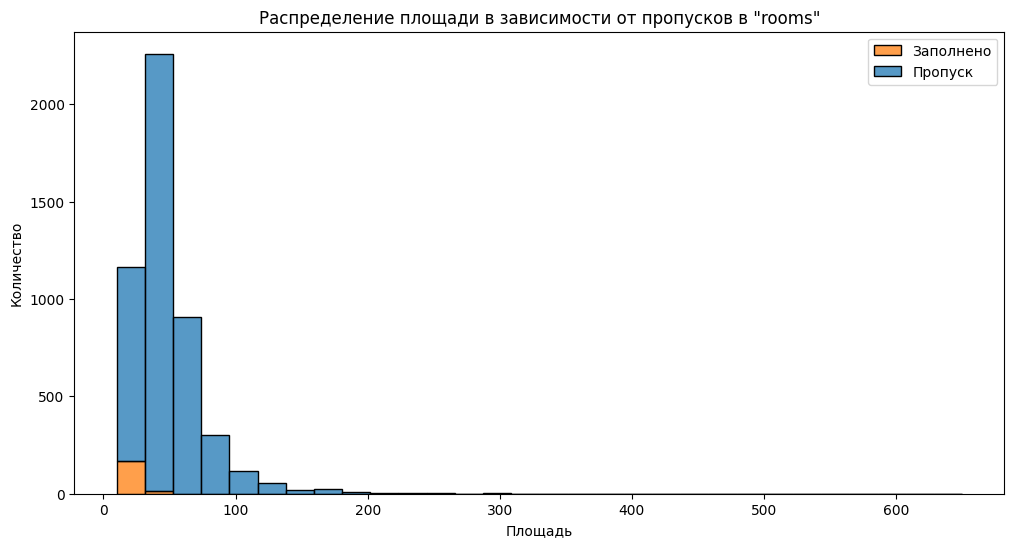

In [15]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df_mk, x='area', hue=df_mk['rooms'].isnull(), multiple='stack', bins=30)
plt.title('Распределение площади в зависимости от пропусков в "rooms"')
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.legend(['Заполнено', 'Пропуск'])
plt.show()

Как видно на графике, пропуски сосредоточены на объектах с небольшой площадью.

Гипотеза - это могут быть студии:

In [16]:
df_mk[(df_mk['rooms'].isna()) & (df_mk['description'].str.contains('студия|студию', case=False, na=False))]['id'].count()

np.int64(93)

93 из 186 объявлений с пропусками содержат в описании слово "студия".

Предлагаю также использовать комплексный подход: в случаях, где в описании явно указано слово "студия", заполним соответствующим значением; в случаях же, когда описание нас не спасает - разделять данные на корзины по площади (из ДЗ №1 стало ясно, что количество комнат очень сильно кореллирует с площадью) и заполнять `rooms` медианным значением по корзине.

Сохраним распределение по комнатам и количество пропусков до заполнения:

In [17]:
before_fill = df_mk['rooms'].value_counts(dropna=False).sort_index()
initial_nulls = df_mk['rooms'].isna().sum()

Заполним пропуски предложенным методом:

In [18]:
studio_pattern = 'студия|студию'
df_mk.loc[(df_mk['rooms'].isna()) & 
          (df_mk['description'].str.contains(studio_pattern, case=False, na=False)), 
          'rooms'] = 0

# Заполнение остальных пропусков на основе площади
area_groups = pd.qcut(df_mk['area'], q=15)
df_mk['rooms'] = df_mk.groupby(area_groups)['rooms'].transform(
    lambda x: x.fillna(round(x.median()))
)

C:\Users\popov\AppData\Local\Temp\ipykernel_22324\2455071808.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mk['rooms'] = df_mk.groupby(area_groups)['rooms'].transform(


Сохраним распределение по комнатам после заполнения пропусков:

In [19]:
after_fill = df_mk['rooms'].value_counts(dropna=False).sort_index()
resulting_nulls = df_mk['rooms'].isna().sum()

Построим визуализацию, чтобы увидеть, как изменилось распределение по комнатам:

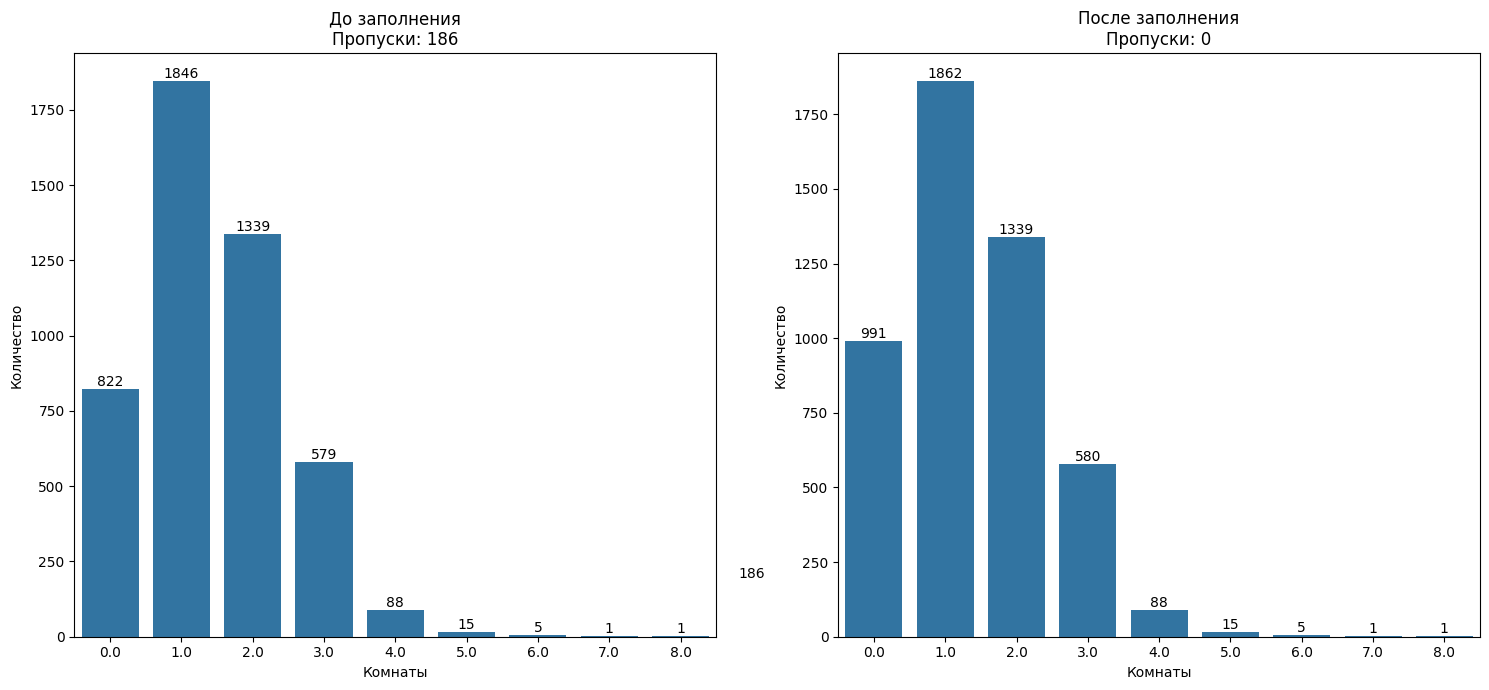

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

bars1 = sns.barplot(x=before_fill.index, y=before_fill.values, ax=ax1)
ax1.set_title(f'До заполнения\nПропуски: {initial_nulls}')
ax1.set_xlabel('Комнаты')
ax1.set_ylabel('Количество')

for i, v in enumerate(before_fill.values):
    ax1.text(i, v, str(int(v)), ha='center', va='bottom')


bars2 = sns.barplot(x=after_fill.index, y=after_fill.values, ax=ax2)
ax2.set_title(f'После заполнения\nПропуски: {resulting_nulls}')
ax2.set_xlabel('Комнаты')
ax2.set_ylabel('Количество')
for i, v in enumerate(after_fill.values):
    ax2.text(i, v, str(int(v)), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Судя по графику, заполнение пропусков более всего зааффектило студии (0 комнат) и гораздо меньше 1-, 2- и 3-комнатные квартиры. Начиная с четырешек, заполнение пропусков ничего не изменило в распределении.

Это кажется логичным, так как большее количество в исходных пропусках было сосредоточено в зоне объектов с небольшой площадью.

#### 3 Столбец `description`

Столбец `description` - последний с пропусками - содержит всего 1 пропуск. Рациональным решением кажется удалить эту единственную строку, т.к. общий объем данных это позволяет.

In [21]:
df_mk = df_mk.dropna(subset=['description'])

Ура! В нашем наборе данных **больше нет пропусков**.

### Аномалии и выбросы

In [22]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [23]:
df_mk.describe(percentiles=[.01, .25, .5, .75, .99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
id,4881.00,338877771.10,3780847.76,207715078.00,326922325.40,338449259.00,340192630.00,340763837.00,341023548.00,341124768.00
price,4881.00,79694.20,910487.91,12000.00,20000.00,30000.00,40000.00,55000.00,262000.00,39006800.00
latitude,4881.00,59.93,0.09,59.68,59.73,59.86,59.93,60.01,60.08,60.24
longitude,4881.00,30.33,0.12,29.51,29.90,30.25,30.34,30.41,30.54,30.65
photos_count,4881.00,15.93,7.24,1.00,7.00,10.00,14.00,20.00,39.20,68.00
rooms,4881.00,1.38,1.03,0.00,0.00,1.00,1.00,2.00,4.00,8.00
area,4881.00,48.13,28.67,10.00,17.36,32.00,41.00,56.00,160.80,650.00
floor,4881.00,7.04,5.22,1.00,1.00,3.00,5.00,10.00,23.00,29.00
total_floors,4881.00,12.77,6.78,1.00,3.00,7.00,12.00,17.00,27.00,38.00
price_per_sqm,4881.00,1312.53,6738.60,54.50,509.98,812.50,1000.00,1263.16,3032.94,280624.46


Можно выявить несколько потенциальных проблем с выбросами:

1. **`price` (цена):** 
   - Максимальное значение (3,900,680) значительно превышает 99-й перцентиль (262,000).

2. **`area` (площадь):** 
   - Максимальное значение (650) также существенно превышает 99-й перцентиль (160.8).

3. **`price_per_sqm` (цена за кв.м):**
   - Максимальное значение (280,624.46) чрезвычайно большое по сравнению с 99-м перцентилем (3,032.39).

4. **`dist_to_metro`, `dist_to_park`, `dist_to_water`, `dist_to_airport` (расстояния):**
   - Значения, сильно превышающие 99-й перцентиль, могут указывать на аномалии или ошибки в данных.

5. **`rooms` (количество комнат):**
   - Хотя максимум (8) не выглядит очевидным выбросом, его стоит проверить.

Эти выбросы могут быть результатом ошибок сбора данных или представлять редкие, но реальные случаи. Нужно дополнительно исследовать эти значения, чтобы определить, следует ли их корректировать или удалять.

Площадь действительно составляет 650 м2.

#### Сравнение методов удаления выбросов

##### Удаление выбросов с использованием перцентилей

In [24]:
def remove_outliers(df, column):
    lower_bound = df[column].quantile(0.01)
    upper_bound = df[column].quantile(0.99)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

##### Удаление выбросов с использованием Z-оценки

In [25]:
def remove_outliers_zscore(df, column):
    z_scores = stats.zscore(df[column])
    abs_z_scores = abs(z_scores)
    return df[abs_z_scores < 3]

##### Удаление выбросов на основе интерквартильного размаха

In [26]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

##### Сравнение методов

In [27]:
count_no_outliers_price = len(remove_outliers(df_mk, 'price'))
count_no_outliers_area = len(remove_outliers(df_mk, 'area'))
count_no_outliers_price_per_sqm = len(remove_outliers(df_mk, 'price_per_sqm'))
count_no_outliers_dist_to_metro = len(remove_outliers(df_mk, 'dist_to_metro'))

count_no_z_outliers_price = len(remove_outliers_zscore(df_mk, 'price'))
count_no_z_outliers_area = len(remove_outliers_zscore(df_mk, 'area'))
count_no_z_outliers_price_per_sqm = len(remove_outliers_zscore(df_mk, 'price_per_sqm'))
count_no_z_outliers_dist_to_metro = len(remove_outliers_zscore(df_mk, 'dist_to_metro'))

count_no_iqr_outliers_price = len(remove_outliers_iqr(df_mk, 'price'))
count_no_iqr_outliers_area = len(remove_outliers_iqr(df_mk, 'area'))
count_no_iqr_outliers_price_per_sqm = len(remove_outliers_iqr(df_mk, 'price_per_sqm'))
count_no_iqr_outliers_dist_to_metro = len(remove_outliers_iqr(df_mk, 'dist_to_metro'))

print(f"Original count: {len(df_mk)}")
print("*******************************************************")
print(f"Price (Percentile): {count_no_outliers_price}")
print(f"Area (Percentile): {count_no_outliers_area}")
print(f"Price per sqm (Percentile): {count_no_outliers_price_per_sqm}")
print(f"Dist to metro (Percentile): {count_no_outliers_dist_to_metro}")

print("*******************************************************")
print(f"Price (Z-score): {count_no_z_outliers_price}")
print(f"Area (Z-score): {count_no_z_outliers_area}")
print(f"Price per sqm (Z-score): {count_no_z_outliers_price_per_sqm}")
print(f"Dist to metro (Z-score): {count_no_z_outliers_dist_to_metro}")

print("*******************************************************")
print(f"Price (IQR): {count_no_iqr_outliers_price}")
print(f"Area (IQR): {count_no_iqr_outliers_area}")
print(f"Price per sqm (IQR): {count_no_iqr_outliers_price_per_sqm}")
print(f"Dist to metro (IQR): {count_no_iqr_outliers_dist_to_metro}")

Original count: 4881
*******************************************************
Price (Percentile): 4806
Area (Percentile): 4783
Price per sqm (Percentile): 4783
Dist to metro (Percentile): 4783
*******************************************************
Price (Z-score): 4877
Area (Z-score): 4800
Price per sqm (Z-score): 4877
Dist to metro (Z-score): 4777
*******************************************************
Price (IQR): 4403
Area (IQR): 4614
Price per sqm (IQR): 4566
Dist to metro (IQR): 4359


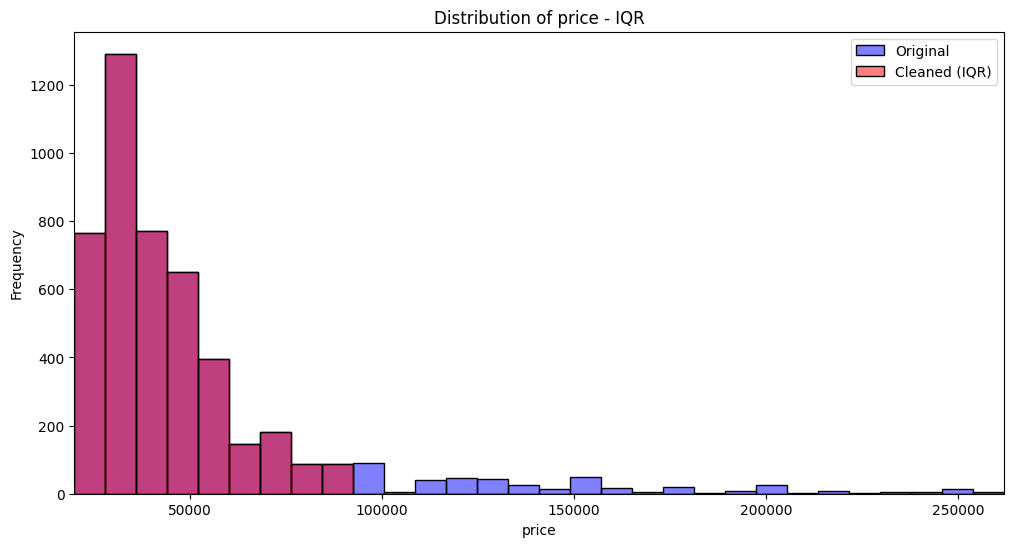

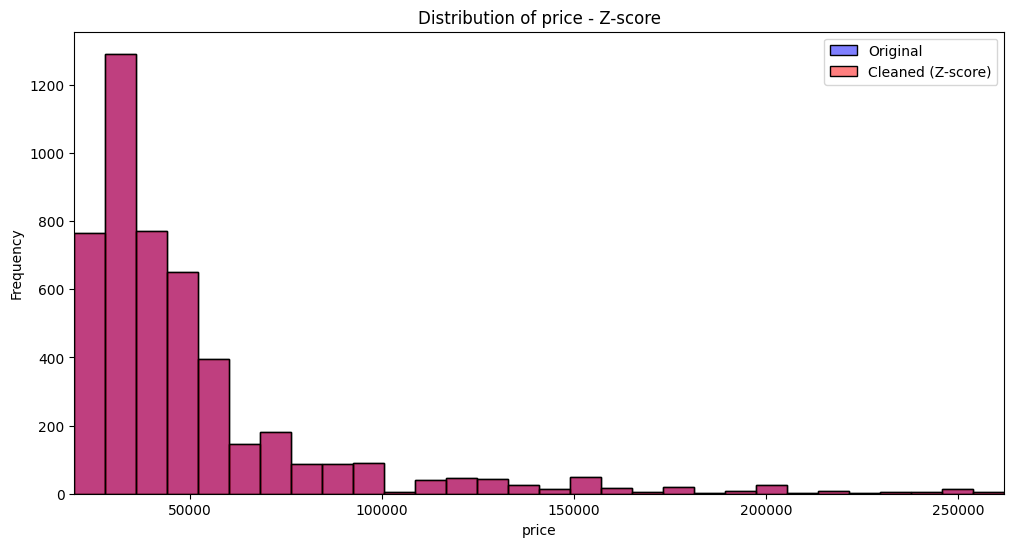

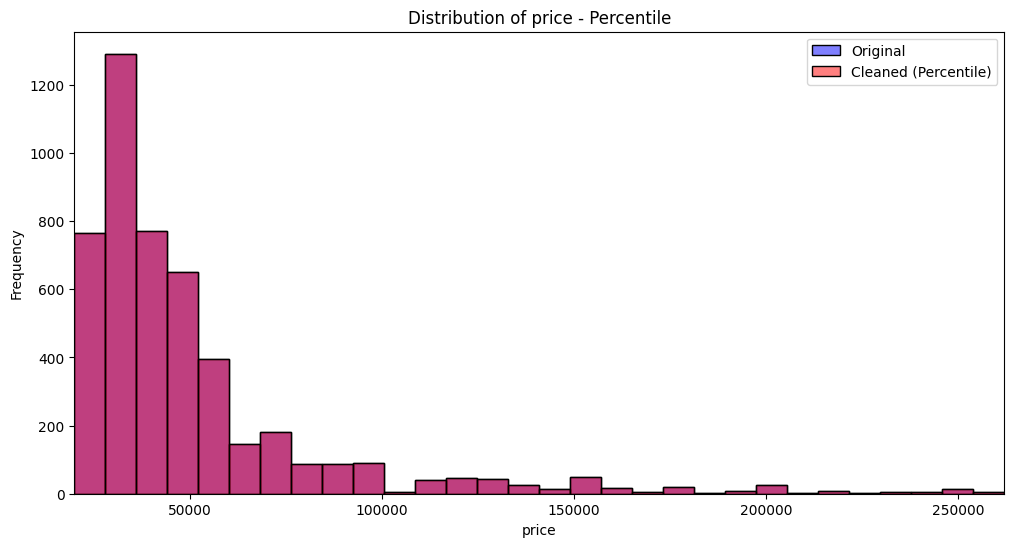

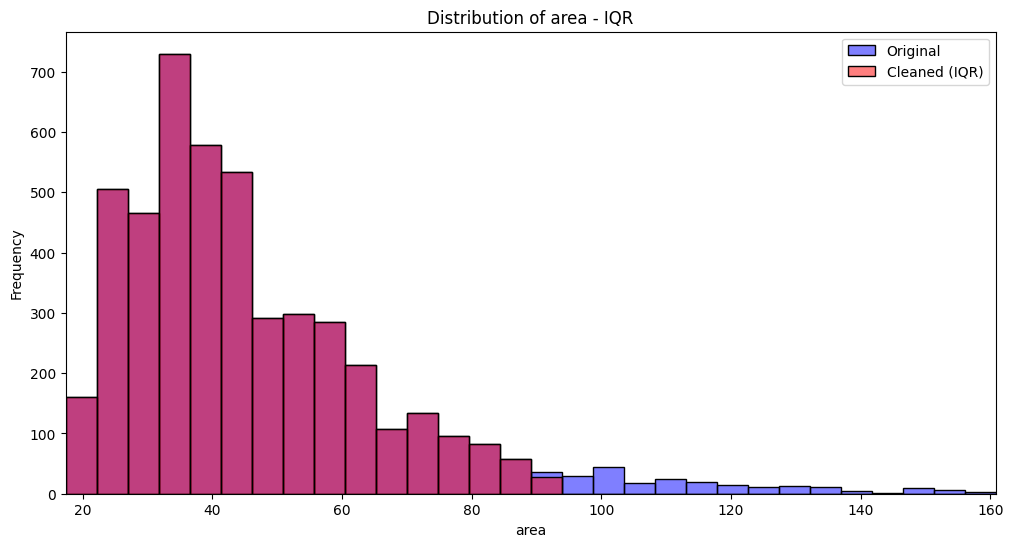

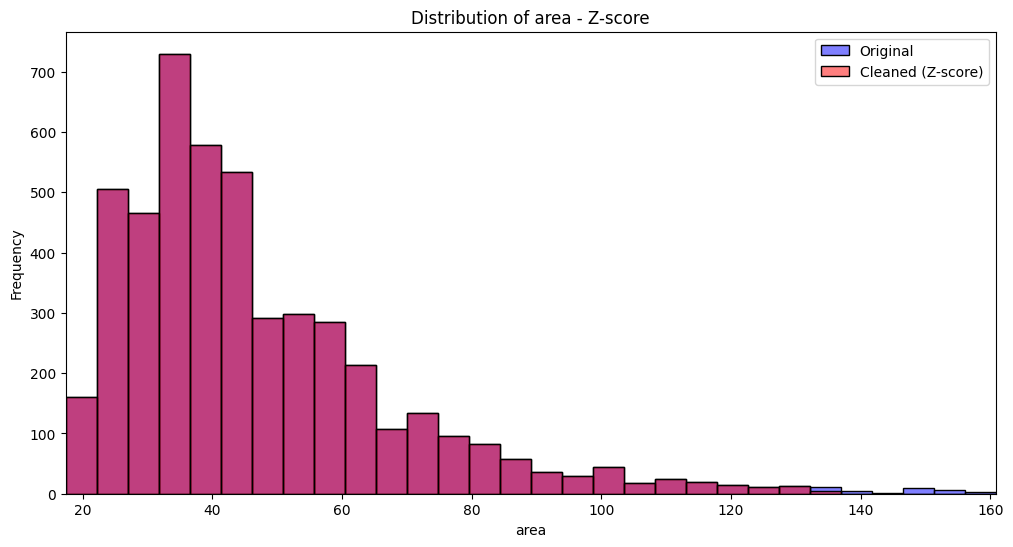

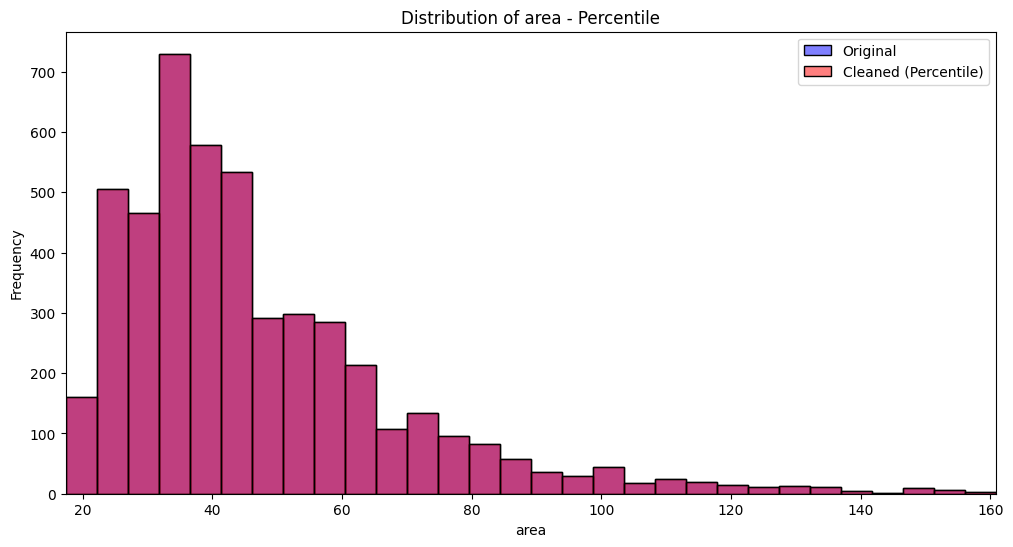

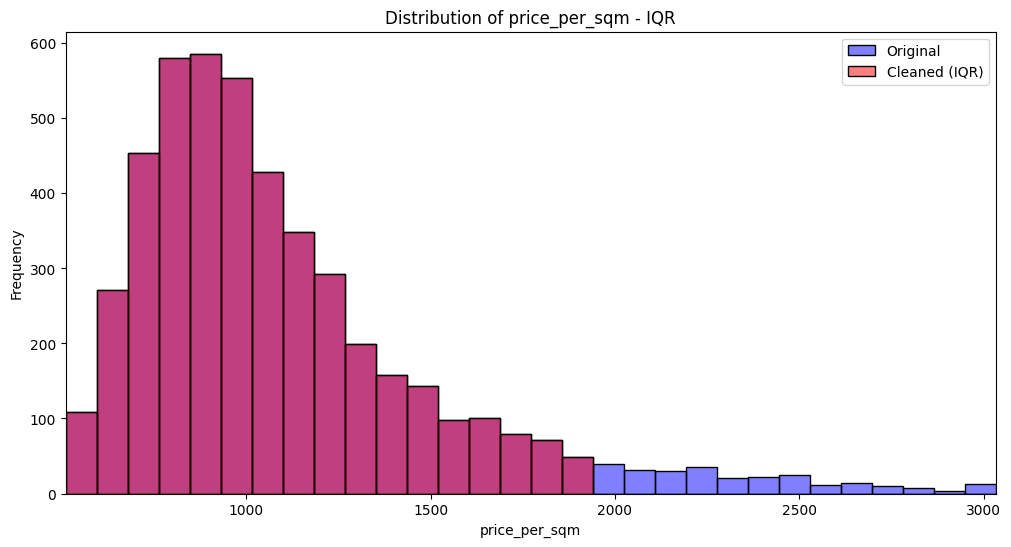

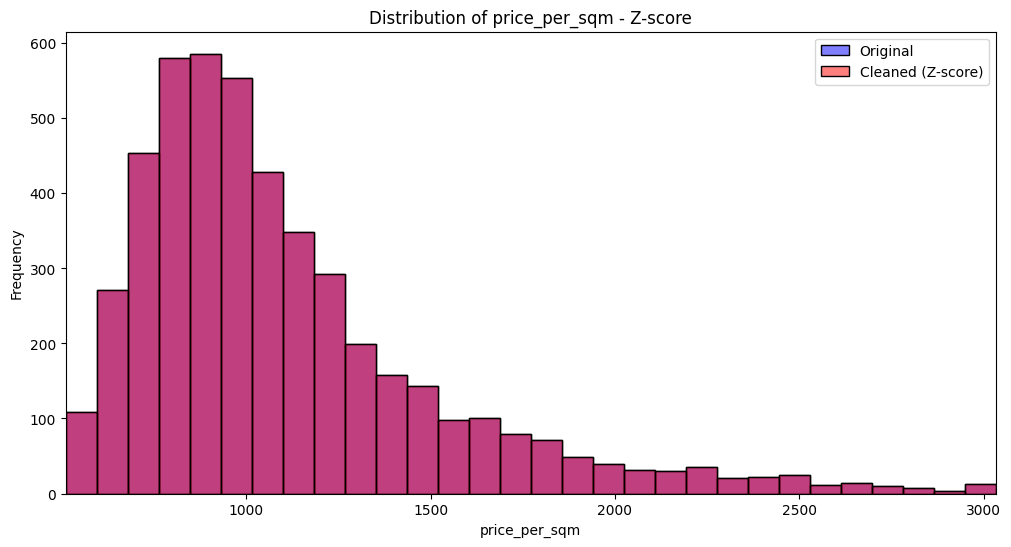

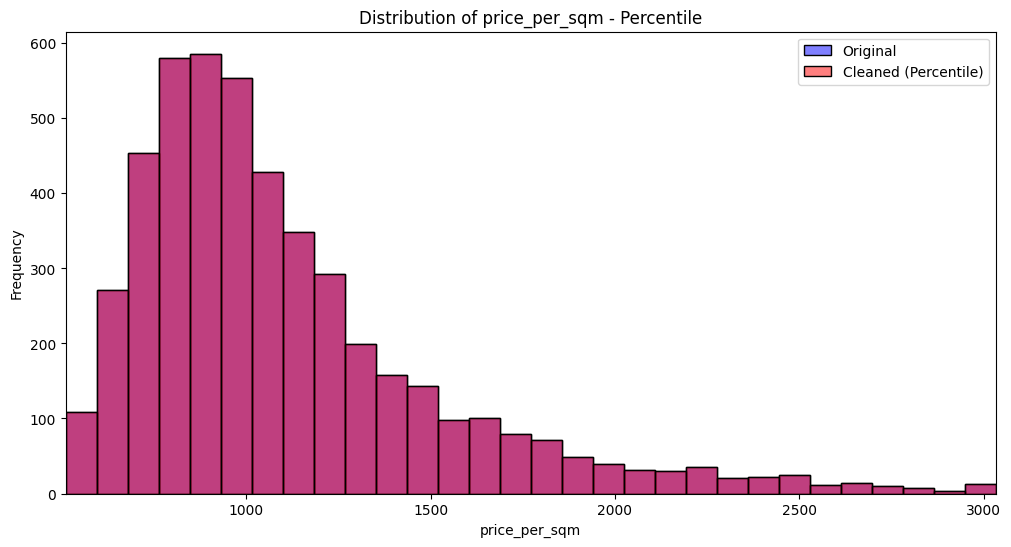

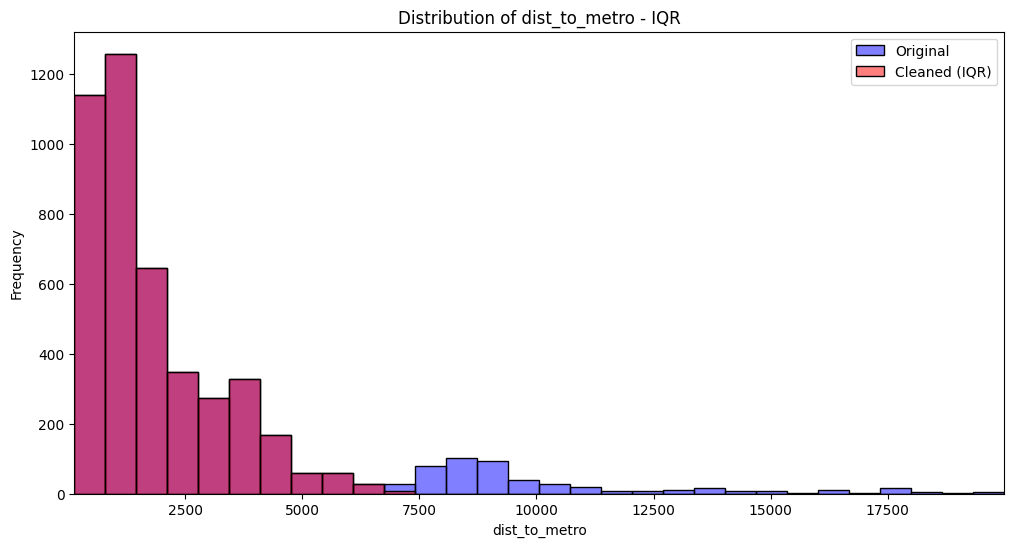

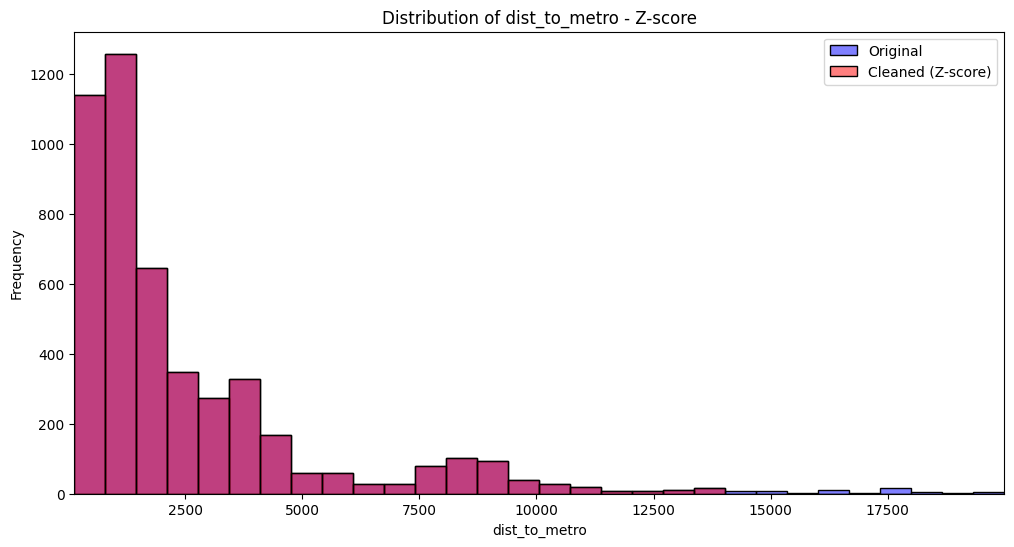

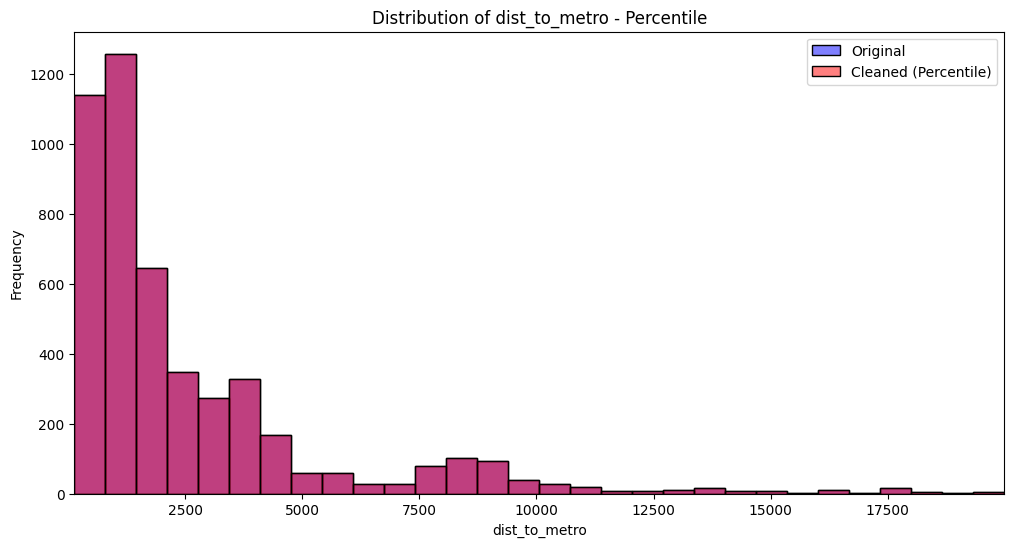

In [28]:
def plot_distribution(original_df, cleaned_df, column, method):
    plt.figure(figsize=(12, 6))
    
    max_val = np.percentile(original_df[column], 99)
    min_val = np.percentile(original_df[column], 1)
    
    bins = np.linspace(min_val, max_val, 31)
    
    sns.histplot(data=original_df[original_df[column] <= max_val], 
                x=column, bins=bins, 
                color='blue', alpha=0.5, 
                label='Original')
    
    sns.histplot(data=cleaned_df[cleaned_df[column] <= max_val], 
                x=column, bins=bins, 
                color='red', alpha=0.5, 
                label=f'Cleaned ({method})')
    
    plt.title(f'Distribution of {column} - {method}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    
    plt.xlim(min_val, max_val)
    
    plt.legend()
    plt.show()

for column in ['price', 'area', 'price_per_sqm', 'dist_to_metro']:
    df_no_outliers = remove_outliers_iqr(df_mk, column)
    plot_distribution(df_mk, df_no_outliers, column, 'IQR')
    
    df_no_outliers = remove_outliers_zscore(df_mk, column)
    plot_distribution(df_mk, df_no_outliers, column, 'Z-score')
    
    df_no_outliers = remove_outliers(df_mk, column)
    plot_distribution(df_mk, df_no_outliers, column, 'Percentile')

Как видно из полученных данных, обработка выбросов с помощью IQR - самый жесткий метод, не щадящий данные.

Наиболее хорошо же себя показал Z-score - чтобы сохранить больше данных и правдоподобность в них, буду использовать именно его для более похожих на нормальное распределение столбцов `area` и `price_per_sqm`. Для `dist_to_metro` использую перцентили, чтобы не потерять слишком много данных.

! Выбросы по столбцу `price` дополнительно обрабатывать не стоит, так как уже учитывается более сбалансированная метрика `price_per_sqm`.

In [29]:
df_cleaned = df_mk.copy()

df_cleaned = remove_outliers_zscore(df_cleaned, 'area')
df_cleaned = remove_outliers_zscore(df_cleaned, 'price_per_sqm')
df_cleaned = remove_outliers(df_cleaned, 'dist_to_metro')

print(f"Исходное количество записей: {len(df_mk)}")
print(f"Количество записей после очистки: {len(df_cleaned)}")
print(f"Удалено записей: {len(df_mk) - len(df_cleaned)}")

for column in ['area', 'price_per_sqm', 'dist_to_metro']:
    print(f"\nСтатистика для {column}:")
    print("\nДо очистки:")
    print(df_mk[column].describe())
    print("\nПосле очистки:")
    print(df_cleaned[column].describe())

Исходное количество записей: 4881
Количество записей после очистки: 4702
Удалено записей: 179

Статистика для area:

До очистки:
count   4881.00
mean      48.13
std       28.67
min       10.00
25%       32.00
50%       41.00
75%       56.00
max      650.00
Name: area, dtype: float64

После очистки:
count   4702.00
mean      45.63
std       20.31
min       10.00
25%       32.00
50%       40.00
75%       55.00
max      134.00
Name: area, dtype: float64

Статистика для price_per_sqm:

До очистки:
count     4881.00
mean      1312.53
std       6738.60
min         54.50
25%        812.50
50%       1000.00
75%       1263.16
max     280624.46
Name: price_per_sqm, dtype: float64

После очистки:
count   4702.00
mean    1114.48
std      483.31
min      311.72
25%      812.50
50%     1000.00
75%     1250.00
max     5172.41
Name: price_per_sqm, dtype: float64

Статистика для dist_to_metro:

До очистки:
count    4881.00
mean     2786.31
std      3747.62
min        11.61
25%       804.42
50%      145

In [30]:
df_cleaned.describe(percentiles=[.01, .25, .5, .75, .99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
id,4702.00,338922242.87,3231458.02,293278048.00,326928486.91,338454581.00,340193190.00,340763762.00,341023505.26,341124768.00
price,4702.00,50156.76,36008.04,12000.00,20000.00,30000.00,40000.00,55000.00,200000.00,490000.00
latitude,4702.00,59.93,0.09,59.68,59.73,59.86,59.93,60.01,60.08,60.14
longitude,4702.00,30.33,0.11,29.90,30.08,30.25,30.34,30.42,30.55,30.65
photos_count,4702.00,15.86,7.16,1.00,7.00,10.00,14.00,20.00,39.99,68.00
rooms,4702.00,1.34,0.98,0.00,0.00,1.00,1.00,2.00,4.00,7.00
area,4702.00,45.63,20.31,10.00,17.50,32.00,40.00,55.00,115.00,134.00
floor,4702.00,7.12,5.25,1.00,1.00,3.00,6.00,10.00,23.00,29.00
total_floors,4702.00,12.93,6.77,1.00,3.00,8.00,12.00,17.00,27.00,38.00
price_per_sqm,4702.00,1114.48,483.31,311.72,518.17,812.50,1000.00,1250.00,2977.65,5172.41


___________________________________

### Часть 3: «Раскрытие дела» aka Выводы

Выбор оптимального метода обработки выбросов:

  - Z-score является наиболее эффективным методом для данного набора данных, так как:
    * Сохраняет больше данных по сравнению с IQR (удалено всего 3,67% записей)
    * Обеспечивает более естественное распределение значений
    * Хорошо работает с числовыми параметрами, имеющими приближенное к нормальному распределение (`area`, `price_per_sqm`)
  - Для параметров с несимметричным распределением (`dist_to_metro`) оптимально использовать перцентильный метод

Рекомендации по обработке пропущенных значений:
- Использовать комплексный подход, учитывающий специфику данных:
  * Для геопространственных данных (`metro_name`) - комбинировать анализ координат с пороговыми значениями расстояний
  * Для категориальных переменных (`rooms`) - анализировать связанные признаки (например, площадь) 
  * Для единичных пропусков - удалять записи
- Проверять качество заполнения через анализ распределений до и после обработки

_______________________________________

### Defenition of Done

**Часть 1: «Следствие ведёт детектив»**

✅ Возьмите датасет из задания №1 [Модуль 1. **Введение в сбор данных**]

✅ Проанализируйте пропуски: определите их процент и расположение (случайны ли пропуски или есть закономерность?)

✅ Сформулируйте гипотезу о возможных причинах появления пропусков.

✅ Проанализируйте датасет на выбросы удобным вам методом.



**Часть 2: «Выбор подходящего оружия»**

✅ Примените несколько разных методов работы с пропусками, выбросами.

✅ Приведите данные в единый вид, поработайте над категориальными признаками.

✅ Оцените, как каждый из методов повлиял на распределение данных и результаты простого анализа (например, расчёт среднего или простая регрессия).



**Часть 3: «Раскрытие дела»**

✅ Выберите и обоснуйте самый эффективный метод для вашего набора данных.

✅ Сформулируйте краткую рекомендацию по оптимальному подходу к обработке пропущенных значений в вашем датасете.